In [1]:
import pandas as pd

df = pd.read_csv('final_assignments_from_pool_33247583__09-05-2022.tsv', dtype={'INPUT:id': str})
df = df[pd.isnull(df['GOLDEN:sentiment'])]

In [2]:
from tqdm import tqdm as tq
from collections import Counter

def aggregte_annotations(annotations):
    counter = Counter(annotations)
    if len(counter)==1:
        return annotations[0]
    else:
        mc = counter.most_common(1)
        if mc[0][1]>len(annotations)/2:
            return mc[0][0]
        else:
            return None


texts = []
labels = []
tweet_ids = []
dfs = []

from collections import Counter
for tweet_id in tq(df['INPUT:id'].unique()):
    df_temp = df[df['INPUT:id']==tweet_id]
    sentiment = aggregte_annotations(df_temp['OUTPUT:sentiment'].values)
    if sentiment is None:
        continue
    texts.append(df_temp['INPUT:comment'].values[0])
    tweet_ids.append(tweet_id)
    labels.append(sentiment)
    
print('Class Distribution', Counter(labels))
print('Removed Texts', len(df['INPUT:id'].unique())-len(labels))

100%|██████████| 15000/15000 [00:51<00:00, 292.38it/s]

Class Distribution Counter({'neutral': 5341, 'negative': 3298, 'positive': 2414, 'skip': 1843, 'speech': 496})
Removed Texts 1608


In [5]:
df_filtered = df[df['INPUT:id'].isin(tweet_ids)]

In [6]:
import numpy as np
import krippendorff

class_mapper = {
    'negative': 1,
    'neutral': 2,
    'positive': 3,
    'speech': 4,
    'skip': 5
}

reliability_data = []
for user_id in tq(df_filtered['ASSIGNMENT:worker_id'].unique()):
    reliability_item = [np.nan]*len(tweet_ids)
    for index, row in df_filtered[df_filtered['ASSIGNMENT:worker_id']==user_id].iterrows():
        sentiment = row['OUTPUT:sentiment']
        reliability_item[tweet_ids.index(row['INPUT:id'])] = class_mapper[sentiment]
    reliability_data.append(reliability_item)
    
print("Krippendorff's alpha for nominal metric: ", krippendorff.alpha(reliability_data=reliability_data,
                                                                      level_of_measurement="nominal"))

100%|██████████| 473/473 [00:09<00:00, 51.02it/s] 


Krippendorff's alpha for nominal metric:  0.5048646758342411


In [8]:
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import interval_distance, binary_distance 

distance_mapper = {
    'negative': {
        'negative': 0,
        'neutral': 1,
        'positive': 2,
        'speech': 2,
        'skip': 1
    },
    'neutral': {
        'negative': 1,
        'neutral': 0,
        'positive': 1,
        'speech': 1,
        'skip': 1
    },
    'positive': {
        'negative': 2,
        'neutral': 1,
        'positive': 0,
        'speech': 0,
        'skip': 1
    },
    'speech': {
        'negative': 2,
        'neutral': 1,
        'positive': 0,
        'speech': 0,
        'skip': 1
    },
    'skip': {
        'negative': 1,
        'neutral': 1,
        'positive': 1,
        'speech': 1,
        'skip': 0
    },
}

class_mapper = {
    'negative': 1,
    'neutral': 2,
    'positive': 3,
    'speech': 4,
    'skip': 5
}

def custom_distance(x, y):
    return distance_mapper[x][y]


annotation_triples = []
for _, row in df_filtered.iterrows():
    annotation_triples.append((row['ASSIGNMENT:worker_id'], row['INPUT:id'], row['OUTPUT:sentiment']))

t = AnnotationTask(annotation_triples, distance=binary_distance)
result = t.alpha()
print('binary', result)
t = AnnotationTask(annotation_triples, distance=custom_distance)
result = t.alpha()
print('custom', result)

binary 0.5048646758342411
custom 0.5601312165339509


# Most Common Tokens

In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline

df_final = pd.DataFrame({
    'text': texts,
    'label': labels,
    'id': tweet_ids
})
df_final.to_csv('rusentitweet_v2.csv')

In [60]:
df_final

,text,label,id
0,@varlamov @McFaul На,skip,1327934765807308801
1,велл они всё равно что мусор так что ничего с...,negative,1252943181387350017
2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,1323610669061677056
3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,1336231661160247297
4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,1292421736454127617
...,...,...,...
13387,все пора спать пиздец словила шизу,negative,1310349554911457286
13388,такими темпами я создам новую секту или органи...,neutral,1326638109317066752
13389,"Ты смотрела аниме, завернувшись в одеяло ,пока...",neutral,1333159916505362433
13390,@AlyonaPikachu Пиздануться,negative,1308341976455053312


In [67]:
len(df_final)

13392

In [68]:
15000-13392

1608

In [65]:
c = Counter(df_final['label'])
for label in c.keys():
    print(label, c[label], c[label]/sum(c.values()))

skip 1843 0.1376194743130227
negative 3298 0.2462664277180406
neutral 5341 0.3988201911589008
speech 496 0.037037037037037035
positive 2414 0.18025686977299882


In [51]:
from sklearn.model_selection import train_test_split

df_rusentitweet_train, df_rusentitweet_test= train_test_split(df_final, test_size=0.2, 
                                                              random_state=42, stratify=df_final['label'])


df_rusentitweet_train.to_csv('rusentitweet_train_v2.csv', index=False)
df_rusentitweet_test.to_csv('rusentitweet_test_v2.csv', index=False)

In [52]:
print('Avg length', np.mean([len(text) for text in df_final['text']]))
for label in set(df_final['label']):
    lengths_labels = [len(text) for text in df_final[df_final['label']==label]['text']]
    print('Avg length for ' +label, np.mean(lengths_labels))

Avg length 59.363425925925924
Avg length for skip 51.4145415084102
Avg length for speech 42.711693548387096
Avg length for neutral 59.29938213817637
Avg length for positive 57.851284175642085
Avg length for negative 67.5203153426319


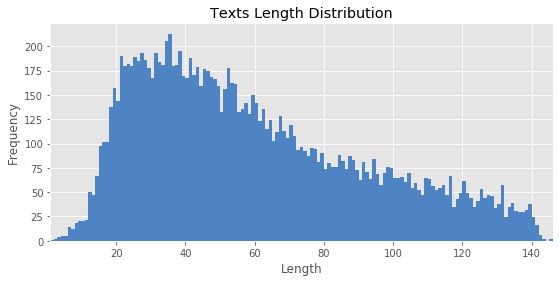

In [49]:
from matplotlib import pyplot as plt
from collections import Counter

plt.style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(9, 4)

lengths = [len(text) for text in df_final['text']]
plt.hist(lengths, bins=len(set(lengths)), color='#4E84C4')
plt.gca().set(ylabel='Frequency', xlabel='Length', title='Texts Length Distribution')
plt.xlim(min(lengths), max(lengths))
plt.show()
fig.savefig('texts_length_distribution.png', dpi=180)

/Users/sismetanin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


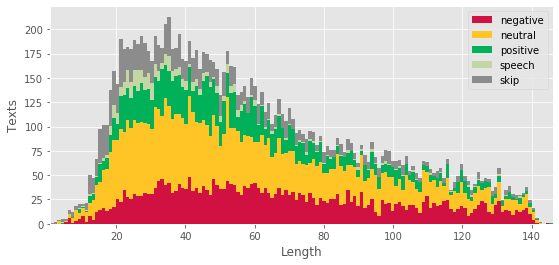

In [53]:
overall_lengths = [len(text) for text in df_final['text']]
lenghts = []

fig = plt.gcf()
fig.set_size_inches(9, 4)
label_names = ['negative', 'neutral', 'positive', 'speech', 'skip']
colors = ["#D16103", "#999999", "#52854C", "#C3D7A4", "#293352"]
colors = ["#d11141", "#ffc425", "#00b159", "#C3D7A4", "#8c8c8c"]
for label in label_names:
    label_lengths = [len(text) for text in df_final[df_final['label']==label]['text']]
    lenghts.append(label_lengths)

plt.hist(lenghts, label=label_names, bins=max(overall_lengths), stacked=True, color=colors)
plt.gca().set(ylabel='Texts', xlabel='Length')#, title='Texts Length Distribution')
plt.gca().set_xlim(min(overall_lengths), max(overall_lengths))
plt.legend()
fig.savefig('texts_length_distribution.png', dpi=180, bbox_inches='tight')
plt.show()

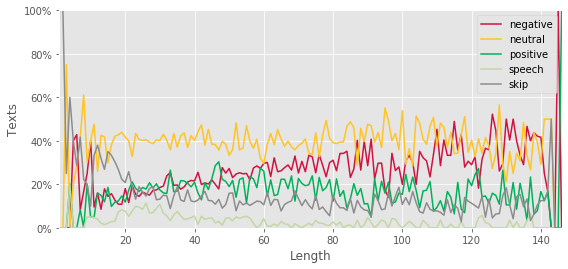

In [48]:
from matplotlib import pyplot as plt
from collections import Counter
import matplotlib.ticker as mtick

def count_lengths(lengths):
    count = [0]*147
    for length in lengths:
        count[length]+=1
    return count

def summ(lengths):
    lengths = np.array(lengths)
    return [sum(lengths[:,i]) for i in range(len(lengths[0]))]

fig = plt.gcf()
fig.set_size_inches(9, 4)

overall_lengths_count = count_lengths([len(text) for text in df_final['text']])
labels = []
lenght_counts = []
label_names = ['negative', 'neutral', 'positive', 'speech', 'skip']
for label in label_names:
    label_lengths = count_lengths([len(text) for text in df_final[df_final['label']==label]['text']])
    for i in range(len(overall_lengths_count)):
        if overall_lengths_count[i] == 0:
            continue
        else:
            label_lengths[i]=label_lengths[i]/overall_lengths_count[i]
    lenght_counts.append(label_lengths)

x = list(range(147))
for i in range(len(lenght_counts)):
    plt.plot(x, lenght_counts[i], label=label_names[i], color=colors[i])

plt.gca().set(ylabel='Texts', xlabel='Length')#, title='Texts Length Distribution')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlim(min(overall_lengths), max(overall_lengths))
plt.ylim(0, 1)
leg = plt.legend(loc=1)
fig.savefig('percentage_texts_length_distribution.png', dpi=180, bbox_inches='tight')
plt.show()

In [42]:
from scipy import stats

for i, lenght_count in enumerate(lenght_counts):
    print(label_names[i], stats.pearsonr(x[5:140], lenght_count[5:140]))

negative (0.6826604835749991, 7.612096640266792e-20)
neutral (-0.03234828754743987, 0.7095536603908441)
positive (-0.04224436047607222, 0.6266211176885871)
speech (-0.5219756165465166, 8.45045127076727e-11)
skip (-0.6292139732252783, 3.012098595346391e-16)


In [43]:
from scipy import stats

for i, lenght_count in enumerate(lenght_counts):
    print(label_names[i], stats.pearsonr(x, lenght_count))

negative (0.5447390266949316, 9.850360234217224e-13)
neutral (0.008005103445077454, 0.9233381427620928)
positive (0.089803334456548, 0.27938593399959066)
speech (-0.4818406674916214, 6.456893113643089e-10)
skip (-0.4770599589431903, 1.0035724033898375e-09)


In [44]:
import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams
import re

tt = TweetTokenizer()

def get_bigrams(texts):
    bigram_fd = nltk.FreqDist()
    for tweet in texts:
        tweet = re.sub('[^а-яА-Я]+', ' ', tweet)
        tweet_tokens = tt.tokenize(tweet.lower())
        bigram_fd.update(nltk.bigrams(tweet_tokens))
    return bigram_fd
    
get_bigrams(texts).most_common(20)    

[(('у', 'меня'), 306),
 (('я', 'не'), 253),
 (('что', 'я'), 134),
 (('потому', 'что'), 121),
 (('что', 'то'), 96),
 (('и', 'не'), 92),
 (('из', 'за'), 82),
 (('не', 'знаю'), 79),
 (('а', 'я'), 73),
 (('у', 'нас'), 71),
 (('не', 'могу'), 69),
 (('что', 'это'), 69),
 (('но', 'я'), 67),
 (('и', 'я'), 66),
 (('я', 'в'), 64),
 (('как', 'же'), 63),
 (('у', 'тебя'), 63),
 (('это', 'не'), 61),
 (('я', 'тоже'), 59),
 (('я', 'уже'), 58)]

In [45]:
def get_unigrams(texts):
    word_fd = nltk.FreqDist()

    for tweet in texts:
        tweet = re.sub('[^а-яА-Я]+', ' ', tweet)
        tweet_tokens = tt.tokenize(tweet.lower())
        word_fd.update(tweet_tokens)
    return word_fd
    
get_unigrams(texts).most_common(10)    

[('я', 2803),
 ('не', 2348),
 ('в', 2292),
 ('и', 2151),
 ('что', 1615),
 ('на', 1379),
 ('это', 1117),
 ('а', 1103),
 ('с', 1021),
 ('как', 834)]

In [50]:
import emoji
from emoji import UNICODE_EMOJI

def select_emojis(tokens):
    emojis = []
    for token in tokens:
        if is_emoji(token):
            emojis.append(token)
    return emojis
            
def is_emoji(s):
    for key in UNICODE_EMOJI.keys():
        if s in UNICODE_EMOJI[key]:
            return True
    return False

def get_emojis(texts):
    word_fd = nltk.FreqDist()

    for tweet in texts:
        tweet_tokens = tt.tokenize(tweet.lower())
        word_fd.update(select_emojis(tweet_tokens))
    return word_fd
    
for token, count in get_emojis(texts).most_common(100):
    print(token, emoji.demojize(token), count)

🥺 :pleading_face: 443
😭 :loudly_crying_face: 313
❤ :red_heart: 246
😂 :face_with_tears_of_joy: 240
🏻 :light_skin_tone: 169
🤣 :rolling_on_the_floor_laughing: 120
💕 :two_hearts: 119
😍 :smiling_face_with_heart-eyes: 118
💜 :purple_heart: 113
😔 :pensive_face: 104
💗 :growing_heart: 100
✨ :sparkles: 90
👍 :thumbs_up: 82
😳 :flushed_face: 79
🥰 :smiling_face_with_hearts: 71
🤔 :thinking_face: 68
💖 :sparkling_heart: 67
💞 :revolving_hearts: 66
♥ :heart_suit: 62
🗿 :moai: 60
✌ :victory_hand: 55
😅 :grinning_face_with_sweat: 52
👈 :backhand_index_pointing_left: 51
👉 :backhand_index_pointing_right: 50
💔 :broken_heart: 48
💓 :beating_heart: 46
♀ :female_sign: 45
🤡 :clown_face: 45
👀 :eyes: 44
😎 :smiling_face_with_sunglasses: 41
✊ :raised_fist: 41
😁 :beaming_face_with_smiling_eyes: 40
😌 :relieved_face: 39
🤧 :sneezing_face: 38
😊 :smiling_face_with_smiling_eyes: 37
😏 :smirking_face: 36
😘 :face_blowing_a_kiss: 35
🖤 :black_heart: 35
💙 :blue_heart: 33
💘 :heart_with_arrow: 30
☺ :smiling_face: 30
😉 :winking_face: 29
